**You may need to install [OpenCV](https://pypi.python.org/pypi/opencv-python) and [scikit-video](http://www.scikit-video.org/stable/).**

In [128]:
import keras
import numpy as np
import io
import base64
from IPython.display import HTML
import skvideo.io
import cv2
import json
import matplotlib.pyplot as plt
from keras.models import Sequential,model_from_json
from keras.layers.core import Dense, Flatten
from keras.optimizers import sgd, adam, Adam
from keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D,Reshape,BatchNormalization

def ma(curve, window_width=10):
    cumsum_vec = np.cumsum(np.insert(curve, 0, 0)) 
    return (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width


# MiniProject #3: Deep Reinforcement Learning

__Notations__: $E_p$ is the expectation under probability $p$. Please justify each of your answer and widely comment your code.

# Context

In a reinforcement learning algorithm, we modelize each step $t$ as an action $a_t$ obtained from a state $s_t$, i.e. $\{(a_{t},s_{t})_{t\leq T}\}$ having the Markov property. We consider a discount factor $\gamma \in [0,1]$ that ensures convergence. The goal is to find among all the policies $\pi$, one that maximizes the expected reward:

\begin{equation*}
R(\pi)=\sum_{t\leq T}E_{p^{\pi}}[\gamma^t r(s_{t},a_{t})] \> ,
\end{equation*}

where: 
\begin{equation*}p^{\pi}(a_{0},a_{1},s_{1},...,a_{T},s_{T})=p(a_{0})\prod_{t=1}^{T}\pi(a_{t}|s_{t})p(s_{t+1}|s_{t},a_{t}) \> .
\end{equation*}

We note the $Q$-function:

\begin{equation*}Q^\pi(s,a)=E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] \> .
\end{equation*}

Thus, the optimal Q function is:
\begin{equation*}
Q^*(s,a)=\max_{\pi}Q^\pi(s,a) \> .
\end{equation*}

In this project, we will apply the deep reinforcement learning techniques to a simple game: an agent will have to learn from scratch a policy that will permit it maximizing a reward.

## The environment, the agent and the game

### The environment

```Environment``` is an abstract class that represents the states, rewards, and actions to obtain the new state.

In [3]:
class Environment(object):
    def __init__(self):
        pass

    def act(self, act):
        """
        One can act on the environment and obtain its reaction:
        - the new state
        - the reward of the new state
        - should we continue the game?

        :return: state, reward, game_over
        """
        pass


    def reset(self):
        """
        Reinitialize the environment to a random state and returns
        the original state

        :return: state
        """
        pass
    
    def draw(self):
        """
        Visualize in the console or graphically the current state
        """
        pass

The method ```act``` allows to act on the environment at a given state $s_t$ (stored internally), via action $a_t$. The method will return the new state $s_{t+1}$, the reward $r(s_{t},a_{t})$ and determines if $t\leq T$ (*game_over*).

The method ```reset``` simply reinitializes the environment to a random state $s_0$.

The method ```draw``` displays the current state $s_t$ (this is useful to check the behavior of the Agent).

We modelize $s_t$ as a tensor, while $a_t$ is an integer.

### The Agent

The goal of the ```Agent``` is to interact with the ```Environment``` by proposing actions $a_t$ obtained from a given state $s_t$ to attempt to maximize its __reward__ $r(s_t,a_t)$. We propose the following abstract class:

In [4]:
class Agent(object):
    def __init__(self, epsilon=0.1, n_action=4):
        self.epsilon = epsilon
        self.n_action = n_action
    
    def set_epsilon(self,e):
        self.epsilon = e

    def act(self,s,train=True):
        """ This function should return the next action to do:
        an integer between 0 and 4 (not included) with a random exploration of epsilon"""
        if train:
            if np.random.rand() <= self.epsilon:
                a = np.random.randint(0, self.n_action, size=1)[0]
            else:
                a = self.learned_act(s)
        else: # in some cases, this can improve the performance.. remove it if poor performances
            a = self.learned_act(s)

        return a

    def learned_act(self,s):
        """ Act via the policy of the agent, from a given state s
        it proposes an action a"""
        pass

    def reinforce(self, s, n_s, a, r, game_over_):
        """ This function is the core of the learning algorithm. 
        It takes as an input the current state s_, the next state n_s_
        the action a_ used to move from s_ to n_s_ and the reward r_.
        
        Its goal is to learn a policy.
        """
        pass

    def save(self):
        """ This function returns basic stats if applicable: the
        loss and/or the model"""
        pass

    def load(self):
        """ This function allows to restore a model"""
        pass

***
__Question 1__:
Explain the function act. Why is ```epsilon``` essential?

The function `act` selects the action that maximizes the $V$ function for a given step. 
The function implements the $\epsilon$-greedy algorithm, that allows sometimes the agent to explore the environment in order to find a better action that those previously learned. 

***
### The Game

The ```Agent``` and the ```Environment``` work in an interlaced way as in the following (take some time to understand this code as it is the core of the project)

```python

epoch = 300
env = Environment()
agent = Agent()


# Number of won games
score = 0
loss = 0


for e in range(epoch):
    # At each epoch, we restart to a fresh game and get the initial state
    state = env.reset()
    # This assumes that the games will end
    game_over = False

    win = 0
    lose = 0
    
    while not game_over:
        # The agent performs an action
        action = agent.act(state)

        # Apply an action to the environment, get the next state, the reward
        # and if the games end
        prev_state = state
        state, reward, game_over = env.act(action)

        # Update the counters
        if reward > 0:
            win = win + reward
        if reward < 0:
            lose = lose -reward

        # Apply the reinforcement strategy
        loss = agent.reinforce(prev_state, state,  action, reward, game_over)

    # Save as a mp4
    if e % 10 == 0:
        env.draw(e)

    # Update stats
    score += win-lose

    print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
          .format(e, epoch, loss, win, lose, win-lose))
    agent.save()
```

# The game, *eat cheese*

A rat runs on an island and tries to eat as much as possible. The island is subdivided into $N\times N$ cells, in which there are cheese (+0.5) and poisonous cells (-1). The rat has a visibility of 2 cells (thus it can see $5^2$ cells). The rat is given a time $T$ to accumulate as much food as possible. It can perform 4 actions: going up, down, left, right. 

The goal is to code an agent to solve this task that will learn by trial and error. We propose the following environment:

In [109]:
class Environment(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))

        # coordinate of the cat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))


    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board>0,0] = 256 # bonus appears in red
        b[self.board < 0, 2] = 256 # malus appears in blue
        b[self.x,self.y,:]=256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)
        self.to_draw[t,:,:,:]=b


    def act(self, action):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        reward = self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((
                               self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

The following elements are important because they correspond to the hyper parameters for this project:

In [110]:
# parameters
size = 13
T = 200
temperature = 0.3
epochs_train = 300 # set small when debugging
epochs_test = 50 # set small when debugging

# display videos
def display_videos(name):
    video = io.open(name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))

__Question 2__ Explain the use of the arrays ```position``` and ```board```.

- `position` contains the borders of (`-1`), the free spaces (`0`) and the position of the mouse (`1`). 
- `board` contains the rewards (`+0.5`) and the penalties (`-1`).

## Random Agent

***
__Question 3__ Implement a random Agent (only ```learned_act``` needs to be implemented):

In [7]:
class RandomAgent(Agent):
    def __init__(self):
        super(RandomAgent, self).__init__()
        pass

    def learned_act(self, s):
        return np.random.randint(0, self.n_action)

***
***
__Question 4__ Visualize the game moves. You need to fill in the following function for the evaluation:

In [111]:
def test(agent, env, epochs, prefix=''):
    # Number of won games
    score = 0
        
    for e in range(1, epochs + 1):
        # Restart the game setup
        state = env.reset()
        terminal = False

        while not terminal:
            # Select an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, terminal = env.act(action)

            # Update stats
            win = max(reward, 0)
            loss = min(reward, 0)
            score += win-loss
        
        # Save as a mp4
        env.draw(prefix + str(e))

    print('Final score: {}'.format(score / epochs))

In [9]:
# Initialize the game
env = Environment(grid_size=size, max_time=T,temperature=temperature)

# Initialize the agent!
agent = RandomAgent()

test(agent,env,epochs_test,prefix='random')

Final score: 39.59


In [ ]:
HTML(display_videos('random1.mp4'))

***
## DQN

Let us assume here that $T=\infty$.

***
__Question 5__ Let $\pi$ be a policy, show that:

\begin{equation*}
Q^{\pi}(s,a)=E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{equation*}

Then, show that for the optimal policy $\pi^*$ (we assume its existence), the following holds: 

\begin{equation*}
Q^{*}(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')].
\end{equation*}
Finally, deduce that a plausible objective is:

\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}




***
The DQN-learning algorithm relies on these derivations to train the parameters $\theta$ of a Deep Neural Network:

1. At the state $s_t$, select the action $a_t$ with best reward using $Q_t$ and store the results;

2. Obtain the new state $s_{t+1}$ from the environment $p$;

3. Store $(s_t,a_t,s_{t+1})$;

4. Obtain $Q_{t+1}$ by minimizing  $\mathcal{L}$ from a recovered batch from the previously stored results.

***
__Question 6__ Implement the class ```Memory``` that stores moves (in a replay buffer) via ```remember``` and provides a ```random_access``` to these. Specify a maximum memory size to avoid side effects. You can for example use a ```list()``` and set by default ```max_memory=100```.

In [112]:
from collections import deque
from random import choices 

class Memory(object):
    def __init__(self, max_memory=100):
        self.max_memory = max_memory
        self.memory = deque(maxlen=max_memory)

    def remember(self, m):
        self.memory.append(m)

    def random_access(self, batch_size=1):
        return choices(self.memory, k=batch_size)

***
The pipeline we will use for training is given below:

In [73]:
def train(agent,env,epoch,prefix=''):
    # Number of won games
    score = 0
    loss = 0
    all_loss, all_win, all_lose = np.zeros(epoch), np.zeros(epoch), np.zeros(epoch)
    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score += win-lose
        all_loss[e], all_win[e], all_lose[e] = loss, win, lose
        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')

    return all_loss, all_win, all_lose

***
__Question 7__ Implement the DQN training algorithm using a cascade of fully connected layers. You can use different learning rate, batch size or memory size parameters. In particular, the loss might oscillate while the player will start to win the games. You have to find a good criterium.

In [113]:
class DQN(Agent):
    def __init__(self, grid_size,  epsilon = 0.1, memory_size=100, batch_size = 16,n_state=2):
        super(DQN, self).__init__(epsilon = epsilon)

        # Discount for Q learning
        self.discount = 0.99
        
        self.grid_size = grid_size
        
        # number of state
        self.n_state = n_state

        # Memory
        self.memory = Memory(memory_size)
        
        # Batch size when learning
        self.batch_size = batch_size

    def learned_act(self, s):
        q = self.model.predict(s.reshape(-1, 5, 5, self.n_state)).ravel()
        return np.argmax(q)

    def reinforce(self, s_, n_s_, a_, r_, game_over_):
        # Two steps: first memorize the states, second learn from the pool
        self.memory.remember([s_, n_s_, a_, r_, game_over_])
        samples = self.memory.random_access(self.batch_size)        
        input_states = np.zeros((self.batch_size, 5, 5, self.n_state))
        next_states = np.zeros((self.batch_size, 5, 5, self.n_state))
        
        for i in range(self.batch_size):
            state, next_state, action, reward, game_over = samples[i]
            input_states[i] = state
            next_states[i] = next_state
            
        q = self.model.predict(input_states)
        q_hat = self.model.predict(next_states)
        target_q = q.copy()
            
        for i in range(self.batch_size):
            state, next_state, action, reward, game_over = samples[i]            
            target_q[i, action] = reward + self.discount * np.max(q_hat[i])
        
        # HINT: Clip the target to avoid exploiding gradients.. -- clipping is a bit tighter
        target_q = np.clip(target_q, -3, 3)

        l = self.model.train_on_batch(input_states, target_q)
        return l
        

    def save(self,name_weights='model.h5',name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        model.compile("adam", "mse")
        self.model = model

            
            
class DQN_FC(DQN):
    def __init__(self, *args, lr=1e-4, **kwargs):
        super(DQN_FC, self).__init__( *args, **kwargs)
        n_actions = 4
        # NN Model
        model = Sequential([
            Flatten(input_shape=(5, 5, self.n_state)),
            Dense(10, activation='relu'),
            Dense(10, activation='relu'),
            Dense(n_actions),
        ])
         
        model.compile(adam(lr=lr), "mse")
        self.model = model

In [74]:
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_FC(size, epsilon = 0.1, memory_size=2000, batch_size = 32)
loss, win, lose = train(agent, env, epochs_train, prefix='fc_train')

Epoch 000/150 | Loss 0.0172 | Win/lose count 4.5/6.0 (-1.5)
Epoch 001/150 | Loss 0.0050 | Win/lose count 6.0/6.0 (0.0)
Epoch 002/150 | Loss 0.0176 | Win/lose count 2.5/3.0 (-0.5)
Epoch 003/150 | Loss 0.0038 | Win/lose count 1.5/5.0 (-3.5)
Epoch 004/150 | Loss 0.0081 | Win/lose count 2.5/2.0 (0.5)
Epoch 005/150 | Loss 0.0136 | Win/lose count 7.0/8.0 (-1.0)
Epoch 006/150 | Loss 0.0096 | Win/lose count 4.0/3.0 (1.0)
Epoch 007/150 | Loss 0.0142 | Win/lose count 6.0/7.0 (-1.0)
Epoch 008/150 | Loss 0.0024 | Win/lose count 2.5/5.0 (-2.5)
Epoch 009/150 | Loss 0.0080 | Win/lose count 2.5/5.0 (-2.5)
Epoch 010/150 | Loss 0.0043 | Win/lose count 2.5/3.0 (-0.5)
Epoch 011/150 | Loss 0.0123 | Win/lose count 4.5/2.0 (2.5)
Epoch 012/150 | Loss 0.0031 | Win/lose count 3.0/2.0 (1.0)
Epoch 013/150 | Loss 0.0026 | Win/lose count 1.5/3.0 (-1.5)
Epoch 014/150 | Loss 0.0109 | Win/lose count 5.5/5.0 (0.5)
Epoch 015/150 | Loss 0.0099 | Win/lose count 5.5/5.0 (0.5)
Epoch 016/150 | Loss 0.0039 | Win/lose count 2.

Epoch 139/150 | Loss 0.0019 | Win/lose count 4.0/2.0 (2.0)
Epoch 140/150 | Loss 0.0061 | Win/lose count 7.0/3.0 (4.0)
Epoch 141/150 | Loss 0.0031 | Win/lose count 9.0/3.0 (6.0)
Epoch 142/150 | Loss 0.0040 | Win/lose count 5.0/2.0 (3.0)
Epoch 143/150 | Loss 0.0091 | Win/lose count 5.5/3.0 (2.5)
Epoch 144/150 | Loss 0.0019 | Win/lose count 5.5/3.0 (2.5)
Epoch 145/150 | Loss 0.0067 | Win/lose count 9.0/6.0 (3.0)
Epoch 146/150 | Loss 0.0109 | Win/lose count 10.5/2.0 (8.5)
Epoch 147/150 | Loss 0.0017 | Win/lose count 5.0/2.0 (3.0)
Epoch 148/150 | Loss 0.0011 | Win/lose count 3.0/6.0 (-3.0)
Epoch 149/150 | Loss 0.0080 | Win/lose count 3.5/2.0 (1.5)


In [ ]:
HTML(display_videos('fc_train10.mp4'))

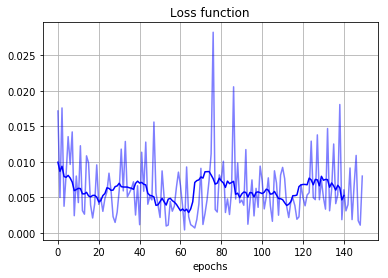

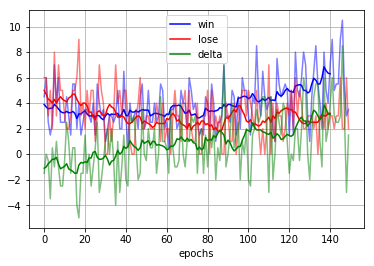

In [90]:
plt.figure()
plt.plot(loss,  color="b", alpha=0.5)
plt.plot(ma(loss),  color="b")
plt.grid('on')
plt.xlabel('epochs')
plt.title('Loss function')
plt.show()

plt.figure()
plt.plot(win,  color="b", alpha=0.5)
plt.plot(ma(win), label='win', color="b")
plt.plot(lose, color="r", alpha=0.5)
plt.plot(ma(lose), label='lose', color="r")
plt.plot(win-lose,color="g", alpha=0.5)
plt.plot(ma(win-lose), label='delta', color="g")
plt.grid('on')
plt.xlabel('epochs')
plt.legend()
plt.show()


***
***
__Question 8__ Implement the DQN training algorithm using a CNN (for example, 2 convolutional layers and one final fully connected layer).

In [114]:
class DQN_CNN(DQN):
    def __init__(self, *args,lr=1e-4,**kwargs):
        super(DQN_CNN, self).__init__(*args,**kwargs)
        
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(5, 5, self.n_state)),
            Conv2D(32, (3, 3), activation='relu', padding="same"),
            Conv2D(32, (3, 3), activation='relu', padding="same"),
            Flatten(),
            Dense(4),
            Dense(4),
        ])
        
        model.summary()
        
        model.compile(adam(lr=lr), "mse")
        self.model = model

In [93]:
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=1e-4, epsilon = 0.1, memory_size=2000, batch_size = 32)
loss, win, lose = train(agent,env,epochs_train,prefix='cnn_train')
HTML(display_videos('cnn_train290.mp4'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 5, 5, 32)          608       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 5, 5, 32)          9248      
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 5, 5, 32)          9248      
_________________________________________________________________
flatten_26 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 4)                 3204      
_________________________________________________________________
dense_58 (Dense)             (None, 4)                 20        
Total params: 22,328
Trainable params: 22,328
Non-trainable params: 0
_________________________________________________________________
Epoch 

Epoch 119/300 | Loss 0.0005 | Win/lose count 21.5/5.0 (16.5)
Epoch 120/300 | Loss 0.0006 | Win/lose count 8.0/1.0 (7.0)
Epoch 121/300 | Loss 0.0002 | Win/lose count 13.5/3.0 (10.5)
Epoch 122/300 | Loss 0.0020 | Win/lose count 14.0/2.0 (12.0)
Epoch 123/300 | Loss 0.0007 | Win/lose count 9.0/2.0 (7.0)
Epoch 124/300 | Loss 0.0005 | Win/lose count 15.5/5.0 (10.5)
Epoch 125/300 | Loss 0.0008 | Win/lose count 21.0/1.0 (20.0)
Epoch 126/300 | Loss 0.0015 | Win/lose count 8.0/2.0 (6.0)
Epoch 127/300 | Loss 0.0004 | Win/lose count 22.0/1.0 (21.0)
Epoch 128/300 | Loss 0.0007 | Win/lose count 8.5/2.0 (6.5)
Epoch 129/300 | Loss 0.0009 | Win/lose count 11.5/2.0 (9.5)
Epoch 130/300 | Loss 0.0004 | Win/lose count 24.5/1.0 (23.5)
Epoch 131/300 | Loss 0.0007 | Win/lose count 21.0/1.0 (20.0)
Epoch 132/300 | Loss 0.0008 | Win/lose count 12.0/4.0 (8.0)
Epoch 133/300 | Loss 0.0008 | Win/lose count 17.5/2.0 (15.5)
Epoch 134/300 | Loss 0.0007 | Win/lose count 13.0/1.0 (12.0)
Epoch 135/300 | Loss 0.0004 | Win/

Epoch 255/300 | Loss 0.0003 | Win/lose count 15.5/2.0 (13.5)
Epoch 256/300 | Loss 0.0005 | Win/lose count 21.5/3.0 (18.5)
Epoch 257/300 | Loss 0.0005 | Win/lose count 15.5/4.0 (11.5)
Epoch 258/300 | Loss 0.0008 | Win/lose count 27.5/1.0 (26.5)
Epoch 259/300 | Loss 0.0006 | Win/lose count 20.5/3.0 (17.5)
Epoch 260/300 | Loss 0.0004 | Win/lose count 22.5/2.0 (20.5)
Epoch 261/300 | Loss 0.0001 | Win/lose count 16.5/2.0 (14.5)
Epoch 262/300 | Loss 0.0004 | Win/lose count 19.5/4.0 (15.5)
Epoch 263/300 | Loss 0.0005 | Win/lose count 10.0/5.0 (5.0)
Epoch 264/300 | Loss 0.0004 | Win/lose count 9.5/2.0 (7.5)
Epoch 265/300 | Loss 0.0004 | Win/lose count 16.5/4.0 (12.5)
Epoch 266/300 | Loss 0.0004 | Win/lose count 18.5/2.0 (16.5)
Epoch 267/300 | Loss 0.0005 | Win/lose count 20.5/3.0 (17.5)
Epoch 268/300 | Loss 0.0005 | Win/lose count 5.0/1.0 (4.0)
Epoch 269/300 | Loss 0.0004 | Win/lose count 17.5/2.0 (15.5)
Epoch 270/300 | Loss 0.0003 | Win/lose count 16.0/5.0 (11.0)
Epoch 271/300 | Loss 0.0007 |

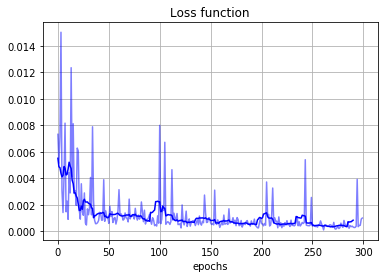

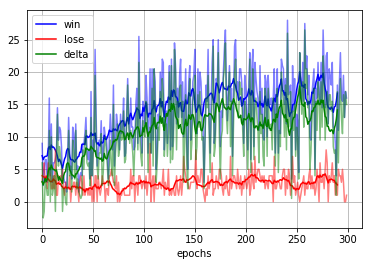

In [94]:
plt.figure()
plt.plot(loss,  color="b", alpha=0.5)
plt.plot(ma(loss),  color="b")
plt.grid('on')
plt.xlabel('epochs')
plt.title('Loss function')
plt.show()

plt.figure()
plt.plot(win,  color="b", alpha=0.5)
plt.plot(ma(win), label='win', color="b")
plt.plot(lose, color="r", alpha=0.5)
plt.plot(ma(lose), label='lose', color="r")
plt.plot(win-lose,color="g", alpha=0.5)
plt.plot(ma(win-lose), label='delta', color="g")
plt.grid('on')
plt.xlabel('epochs')
plt.legend()
plt.show()

***
***
__Question 9__ Test both algorithms and compare their performances. Which issue(s) do you observe? Observe also different behaviors by changing the temperature.

In [95]:
env = Environment(grid_size=size, max_time=T,temperature=0.3)
agent_cnn = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='cnn_trainmodel.h5',name_model='cnn_trainmodel.json')

agent_fc = DQN_FC(size, lr=1e-4, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='fc_trainmodel.h5',name_model='fc_trainmodel.json')
print('Test of the CNN')
test(agent_cnn,env,epochs_test,prefix='cnn_test')
print('Test of the FC')
test(agent_fc,env,epochs_test,prefix='fc_test')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 5, 5, 32)          608       
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 5, 5, 32)          9248      
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 5, 5, 32)          9248      
_________________________________________________________________
flatten_27 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 4)                 3204      
_________________________________________________________________
dense_60 (Dense)             (None, 4)                 20        
Total params: 22,328
Trainable params: 22,328
Non-trainable params: 0
_________________________________________________________________
Test o

In [27]:
HTML(display_videos('cnn_test40.mp4'))

In [28]:
HTML(display_videos('fc_test40.mp4'))

A CNN-based architecture outperforms an FC-based architecture. This is expected: the states have translation invariance that are exploited with convolutions. 

However, both models suffer from limitations.


- First, the agent tends to bounce back and forward around the same point. Adding a new state allowing the agent to do nothing might improve this situation.
- Secondly, the agent tends to remain in a small area where it has more confidence that it will not take penalty. Doing so, the agent limits itself from greater bonus.
- As a result, the agent did not explore all the area and it is far from the maximal reward. 

Changing the temperature affects the proportion of bonus and malus on the grid. An optimal could be found in which the agent is encouraged to explore towards more bonus (for example when bonuses are continuously displaced) but is discouraged by meeting too many malus (for exmaple when maluses are too likely to be met).

Forcing the agent is one solution explored thereafter. Another solution might rely on a penalty time in which the agent's reward is reduced when it took too much time between two bonuses.


***

The algorithm tends to not explore the map which can be an issue. We propose two ideas in order to encourage exploration:
1. Incorporating a decreasing $\epsilon$-greedy exploration. You can use the method ```set_epsilon```
2. Append via the environment a new state that describes if a cell has been visited or not

***
__Question 10__ Design a new ```train_explore``` function and environment class ```EnvironmentExploring``` to tackle the issue of exploration.



In [118]:
def train_explore(agent,env,epoch,epsilon_start=0.7, epsilon_end=0.1, epsilon_decay=60000, prefix=''):
    # Number of won games
    score = 0
    loss = 0
    all_loss, all_win, all_lose = np.zeros(epoch), np.zeros(epoch), np.zeros(epoch)
    
    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        print(state.shape)
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state, train=True)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action, train=True)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))
            update_eps = epsilon_start + (epsilon_end - epsilon_start) * (e+1) / epsilon_decay
            agent.set_epsilon(update_eps)

        # Update stats
        score += win-lose
        
        all_loss[e], all_win[e], all_lose[e] = loss, win, lose
        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
        
    return all_loss, all_win, all_lose


class EnvironmentExploring(Environment):
    def __init__(self, grid_size=10, **kwargs):
        super().__init__(**kwargs)
        self.malus_position = np.zeros((grid_size,grid_size))


    def act(self, action, train=False):
        """This function returns the new state, reward and decides if the
        game ends."""

        state, reward, game_over = super().act(action)
        
        if train:
            reward -= self.malus_position[self.x, self.y]
        
        self.malus_position[self.x, self.y] = 0.1
        
        state = np.concatenate(
                    (
                        self.malus_position.reshape(self.grid_size, self.grid_size,1),
                        self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)
                    ), axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""
        super().reset()
        self.malus_position = np.zeros((self.grid_size,self.grid_size))
        state = np.concatenate(
                    (
                        self.malus_position.reshape(self.grid_size, self.grid_size,1),
                        self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)
                    ), axis=2)
        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

In [121]:
# Training
epochs_train = 150
env = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, epsilon=0.1, memory_size=4000, batch_size=32, n_state=3)
loss, win, lose = train_explore(agent, env, epochs_train, prefix='cnn_train_explore')
HTML(display_videos('cnn_train_explore10.mp4'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 5, 5, 32)          896       
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 5, 5, 32)          9248      
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 5, 5, 32)          9248      
_________________________________________________________________
flatten_36 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 4)                 3204      
_________________________________________________________________
dense_79 (Dense)             (None, 4)                 20        
Total params: 22,616
Trainable params: 22,616
Non-trainable params: 0
_________________________________________________________________
(5, 5,

Epoch 071/150 | Loss 0.0033 | Win/lose count 8.5/31.10000000000013 (-22.60000000000013)
(5, 5, 3)
Epoch 072/150 | Loss 0.0025 | Win/lose count 12.0/22.700000000000035 (-10.700000000000035)
(5, 5, 3)
Epoch 073/150 | Loss 0.0027 | Win/lose count 13.5/20.70000000000004 (-7.200000000000038)
(5, 5, 3)
Epoch 074/150 | Loss 0.0039 | Win/lose count 13.5/20.400000000000023 (-6.9000000000000234)
(5, 5, 3)
Epoch 075/150 | Loss 0.0027 | Win/lose count 12.5/29.600000000000083 (-17.100000000000083)
(5, 5, 3)
Epoch 076/150 | Loss 0.0020 | Win/lose count 8.0/24.300000000000054 (-16.300000000000054)
(5, 5, 3)
Epoch 077/150 | Loss 0.0037 | Win/lose count 13.0/22.100000000000033 (-9.100000000000033)
(5, 5, 3)
Epoch 078/150 | Loss 0.0030 | Win/lose count 15.0/22.100000000000037 (-7.100000000000037)
(5, 5, 3)
Epoch 079/150 | Loss 0.0031 | Win/lose count 13.0/24.600000000000026 (-11.600000000000026)
(5, 5, 3)
Epoch 080/150 | Loss 0.0027 | Win/lose count 8.0/27.00000000000007 (-19.00000000000007)
(5, 5, 3)
E

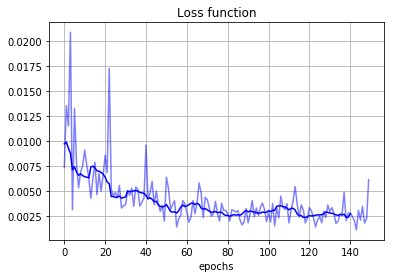

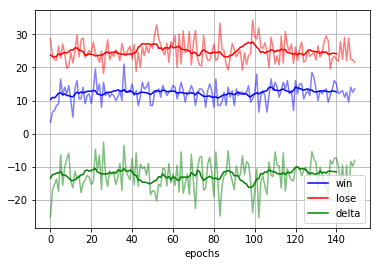

In [122]:
plt.figure()
plt.plot(loss,  color="b", alpha=0.5)
plt.plot(ma(loss),  color="b")
plt.grid('on')
plt.xlabel('epochs')
plt.title('Loss function')
plt.show()

plt.figure()
plt.plot(win,  color="b", alpha=0.5)
plt.plot(ma(win), label='win', color="b")
plt.plot(lose, color="r", alpha=0.5)
plt.plot(ma(lose), label='lose', color="r")
plt.plot(win-lose,color="g", alpha=0.5)
plt.plot(ma(win-lose), label='delta', color="g")
plt.grid('on')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [123]:
# Evaluation
test(agent,env,epochs_test,prefix='cnn_test_explore')
HTML(display_videos('cnn_test_explore10.mp4'))

Final score: 23.67


***
Results are on average improved thanks to the exploration penality. Some parts may remain unexplored, because the agent only sees a small part of the grid. 
Improvements could rely on the storage of a map to find the unexplored map.

***
__BONUS question__ Use the expert DQN from the previous question to generate some winning games. Train a model that mimicks its behavior. Compare the performances.

In [139]:
def generate_winning_games(agent, env, size):
    states = []
    actions = []
        
    while len(states) < size:
        
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will end
        game_over = False

        while not game_over:
            # The agent performs an action
            action = agent.act(state, train=False)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)
            enc_action = np.zeros(4)
            enc_action[action] = 1
            
            if len(states) < size and reward > 0:  # only keep wining examples
                states.append(prev_state)
                actions.append(enc_action)
                
    return np.asarray(states), np.asarray(actions)

def evaluate(agent, env, epochs, prefix=''):
    # Number of won games
    score = 0
    all_win, all_lose = np.zeros(epochs), np.zeros(epochs)
    for e in range(epochs):
        
         # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will end
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.predict(np.expand_dims(state, axis=0))[0].argmax()

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward
        
        # Save as a mp4
        env.draw(prefix+str(e))

        # Update stats
        score = score + win-lose
        all_win[e], all_lose[e] = win, lose
        print(f"Win/lose count {win}/{lose}. Average score ({score/(1+e):.3f})")
    print('Final score: '+str(score/epochs))
    return all_win, all_lose

In [ ]:
dataset_train, target_train = generate_winning_games(agent, env, size=5000)
dataset_val, target_val = generate_winning_games(agent, env, size=100)
dataset_test, target_test = generate_winning_games(agent, env, size=100)

In [ ]:
model = Sequential()
model.add(Conv2D(16, 3, input_shape=(5,5,3),
                 padding='same', activation='relu', name='conv1'))
model.add(Flatten(name='flatten'))
# model.add(Dense(64, activation='relu', name='fc1'))
model.add(Dense(4, activation='softmax', name='fc2'))
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(dataset_train, target_train, batch_size=64, \
                validation_data=(dataset_val, target_val), epochs=50)

In [140]:
win, lose = evaluate(model, env, epochs_train, prefix="imitation_learning")
HTML(display_videos('imitation_learning20.mp4'))

Win/lose count 5.5/0. Average score (5.500)
Win/lose count 13.0/0. Average score (9.250)
Win/lose count 4.0/0. Average score (7.500)
Win/lose count 5.5/0. Average score (7.000)
Win/lose count 14.0/2.0. Average score (8.000)
Win/lose count 8.0/1.0. Average score (7.833)
Win/lose count 10.5/0. Average score (8.214)
Win/lose count 14.0/1.0. Average score (8.812)
Win/lose count 10.5/1.0. Average score (8.889)
Win/lose count 11.0/1.0. Average score (9.000)
Win/lose count 10.5/1.0. Average score (9.045)
Win/lose count 14.0/0. Average score (9.458)
Win/lose count 10.5/2.0. Average score (9.385)
Win/lose count 2.5/0. Average score (8.893)
Win/lose count 10.5/0. Average score (9.000)
Win/lose count 10.0/0. Average score (9.062)
Win/lose count 7.0/0. Average score (8.941)
Win/lose count 3.5/0. Average score (8.639)
Win/lose count 11.5/0. Average score (8.789)
Win/lose count 3.0/0. Average score (8.500)
Win/lose count 12.0/1.0. Average score (8.619)
Win/lose count 8.0/1.0. Average score (8.545)
W

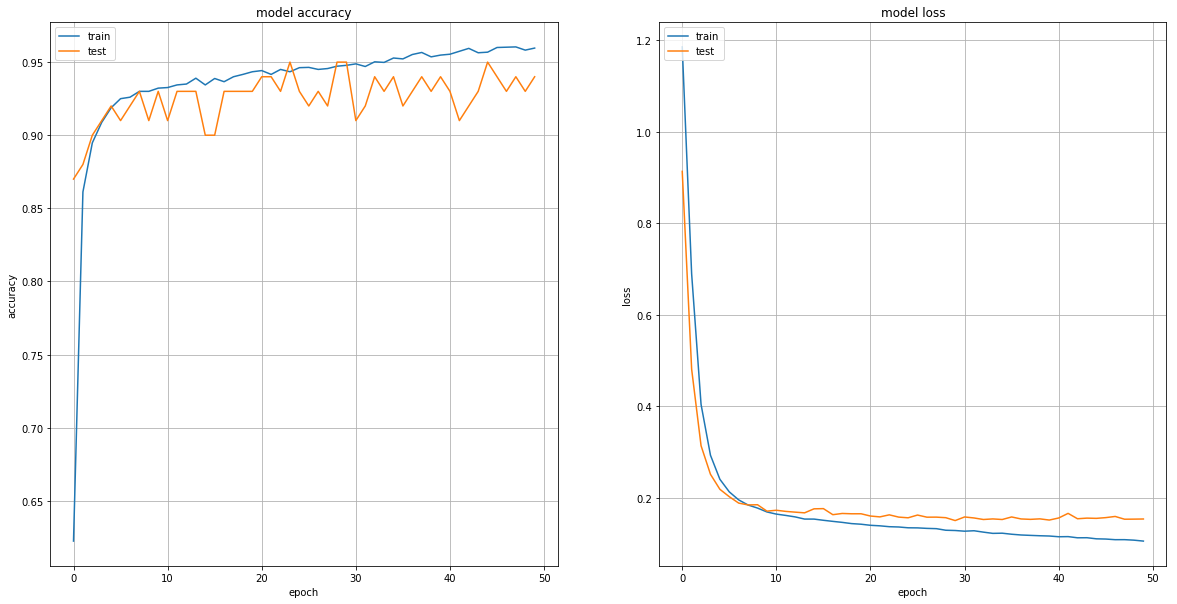

In [141]:
def plot_history(history):
    if 'acc' in history.history:
        plt.figure(figsize=(20,10))
        plt.subplot(121)
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.grid(True)

        plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid(True)
    plt.show()

    
plot_history(history)

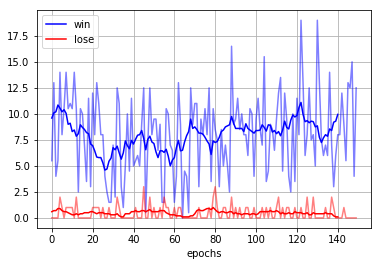

In [143]:
plt.figure()
plt.plot(win,  color="b", alpha=0.5)
plt.plot(ma(win), label='win', color="b")
plt.plot(lose, color="r", alpha=0.5)
plt.plot(ma(lose), label='lose', color="r")
plt.grid('on')
plt.xlabel('epochs')
plt.legend()
plt.show()

In the imitation learning setup, we did not improve results over the teacher. 

It is noticeable that the agent is less prone to get malus than its teacher. This is expected, because we used only successful actions to train the second agent. 

Moreover, it is much faster to train as no exploration is required anymore.

However, the trained agent does not explore enough to maximize its reward.